In [47]:
import os
from astroquery.vizier import Vizier
from astropy.table import Table, join
from scipy.interpolate import interp1d
from scipy.optimize import fsolve
import numpy as np
import astropy.units as u
from astropy.io import ascii, fits
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

rcParams['font.family'] = 'serif'
rcParams['figure.figsize'] = 9, 6
rcParams['axes.titlesize'] = 18
rcParams['axes.labelsize'] = 16
rcParams['legend.fontsize'] = 'large'
rcParams['ytick.labelsize'] = rcParams['xtick.labelsize'] = 14
rcParams['figure.dpi'] = 100

## Import the Kraus & Hillenbrand (2007) Stellar SEDs Data 

Text(0, 0.5, '$M_* / M_\\odot$')

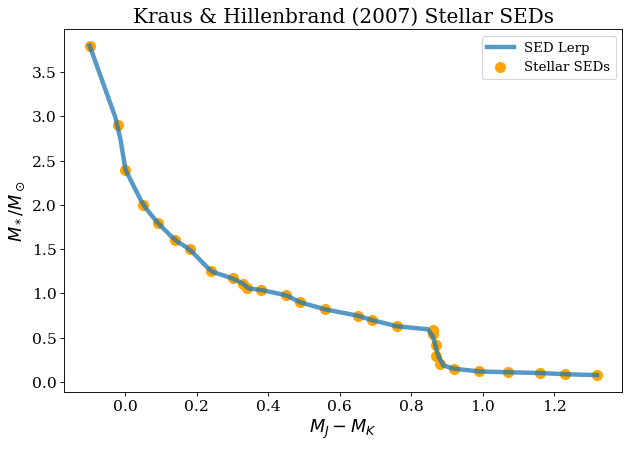

In [40]:
# Import Kraus & Hillenbrand (2007) Table 5, and Extract J-K & Masses columns 
seds_table = ascii.read('StellarModels/Kraus_2007.csv')
kraus_JK = seds_table['MJ'] - seds_table['MK']
kraus_M = seds_table['Msun']

# Create interpolate function to get the masses of any J-K values (within bounds)
KrausMass = interp1d(kraus_JK, kraus_M, kind='slinear')
KrausJK = interp1d(kraus_M, kraus_JK, kind='slinear')

jk_range = np.linspace(kraus_JK[0], kraus_JK[-1], 100)
plt.plot(jk_range, KrausMass(jk_range), lw=4, alpha=0.75, label='SED Lerp')
plt.scatter(kraus_JK, kraus_M, c='orange', alpha=1, s=80, label='Stellar SEDs')
plt.legend()
plt.title('Kraus & Hillenbrand (2007) Stellar SEDs')
plt.xlabel('$M_J - M_K$')
plt.ylabel('$M_* / M_\odot$')

## Import IC2391's Master Target Table & Add Masses targets

In [4]:
# Import master table with periods, and J-K values, then add column with Calculated Masses from Stellar SEDs
master_table = Table(fits.open('master_table.fits')[1].data)
targets = ascii.read('DataInput/cluster_targets_tic.ecsv')

kraus_masses = KrausMass(master_table['j-k'])
master_table.add_column(kraus_masses, name='Kmass')

# Join tables with all the target information
targets.rename_column('TIC ID', 'tic id')
cross_match = join(master_table, targets, keys='tic id')
targets.rename_column('tic id', 'TIC ID')

## Create index masks to get a wide and narrow Solar-like range of targets

All targets that have a meaninful period signal must lie well within the 0.1-1.25 Msun bounds because it doesn't matter which mass measurements I use, I still select the same 51 IC2391 targets.

In [21]:
# Create index mask for periods that have meaningful periodic signals, and use as filter for selection
is_period = (0.1 < cross_match['period']) & (cross_match['period'] < 28.0)
is_valid_period = (0.1 < cross_match['period']) & (cross_match['period'] < 14.0)

# Get row index mask for the master table to get WIDE Solais_periode targets
is_low_kraus = (0.1 < cross_match['Kmass']) & (cross_match['Kmass'] <= 0.75) & is_period
is_low_orig = (0.1 < cross_match['mass']) & (cross_match['mass'] <= 0.75) & is_period

# Get row index mask for the master table to get NARROW Solar-like targets
is_sun_kraus = (0.75 < cross_match['Kmass']) & (cross_match['Kmass'] < 1.25) & is_period
is_sun_orig = (0.75 < cross_match['mass']) & (cross_match['mass'] < 1.25) & is_period

While the individual masses seem to have quite a difference, the categorized masses are still the same

## Import Matt's 50Myr synthetic stars

In [14]:
# The first column is the masses in Msun units?, and the second column is the period in days
m50_models = ascii.read('StellarModels/M20_30-60Myr_simple/Mattea2020_00050Myr.txt', names=['mass', 'period'])
m50UpSco_models = ascii.read('StellarModels/M20_30-60Myr_UpSco/Mattea2020_00050Myr.txt', names=['mass', 'period'])

# Create folder for saved plots
if not os.path.isdir('SyntheticComparison'):
    os.mkdir('SyntheticComparison')

# Few params
fast_period = 0.4
med_period = 6
slow_period = 8

## Plot the synthetic stars with all of IC2391's meaningful periodic signals.

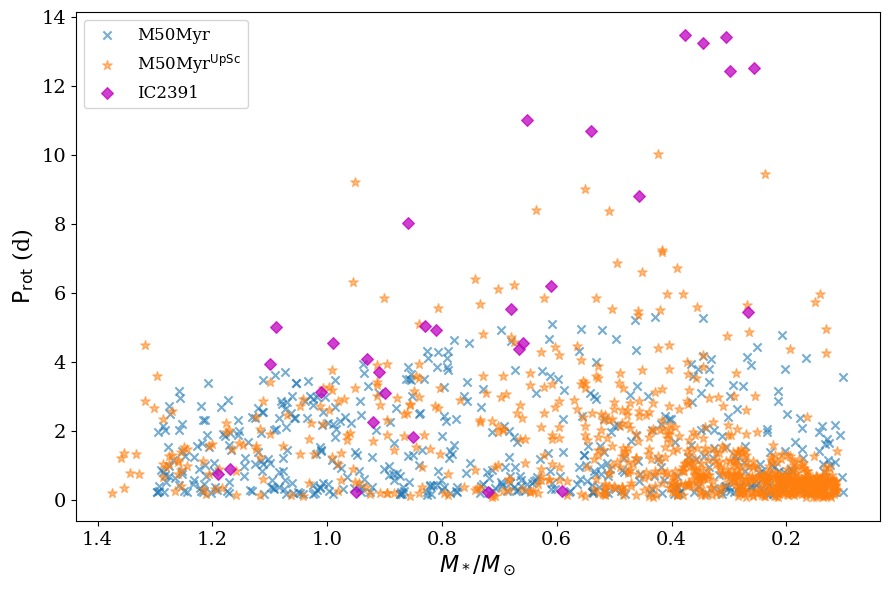

In [48]:
# Now we are ready to plot all the datasets
fig, ax = plt.subplots()

ax.scatter(m50_models['mass'], m50_models['period'], marker='x', s=35, alpha=0.6, label='M50Myr')
ax.scatter(m50UpSco_models['mass'], m50UpSco_models['period'], marker='*', s=50, alpha=0.5, label='M50Myr$^{\mathrm{UpSc}}$')

ax.scatter(cross_match[is_valid_period]['mass'], cross_match[is_valid_period]['period'], 
           marker='D', s=35, c='m', alpha=0.75, label='IC2391')

ax.set_xlabel('$M_*/M_\odot$')
ax.set_ylabel('$\mathrm{P_{rot}}$ (d)')
ax.invert_xaxis()
ax.legend(fontsize=12)
ax.set_rasterized(True)
fig.tight_layout()
plt.savefig('SyntheticComparison/valid_comp.pdf')
plt.savefig('SyntheticComparison/valid_comp.eps')

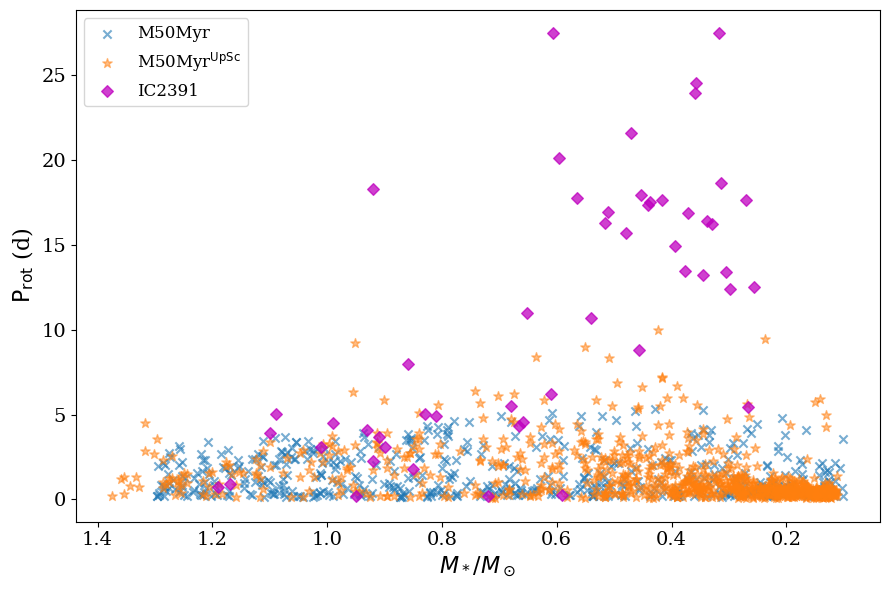

In [49]:
# Now we are ready to plot all the datasets
fig, ax = plt.subplots()

ax.scatter(m50_models['mass'], m50_models['period'], marker='x', s=35, alpha=0.6, label='M50Myr')
ax.scatter(m50UpSco_models['mass'], m50UpSco_models['period'], marker='*', s=50, alpha=0.5, label='M50Myr$^{\mathrm{UpSc}}$')

ax.scatter(cross_match[is_period]['mass'], cross_match[is_period]['period'], 
           marker='D', s=35, c='m', alpha=0.75, label='IC2391')

ax.set_xlabel('$M_*/M_\odot$')
ax.set_ylabel('$\mathrm{P_{rot}}$ (d)')
ax.invert_xaxis()
ax.legend(fontsize=12)
ax.set_rasterized(True)
fig.tight_layout()
plt.savefig('SyntheticComparison/invalid_comp.pdf')
plt.savefig('SyntheticComparison/invalid_comp.eps')

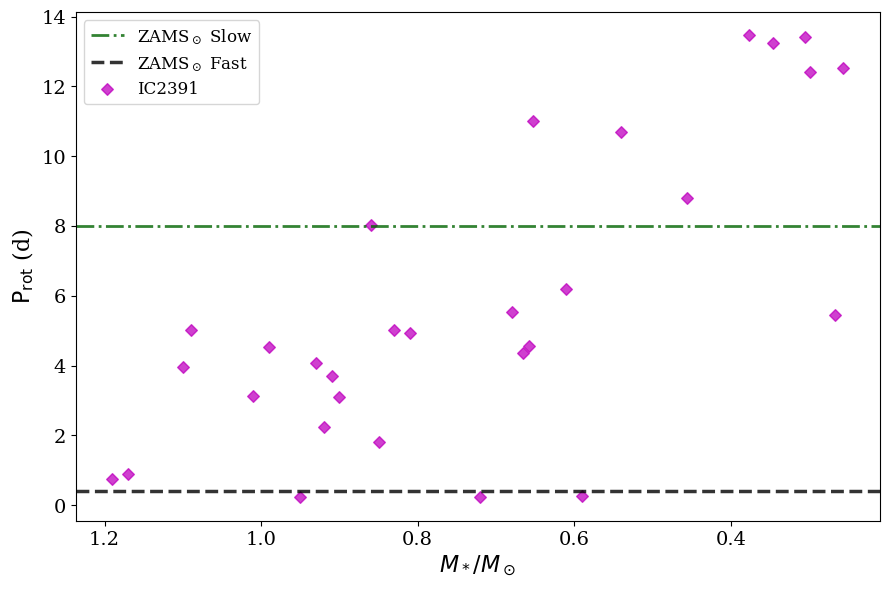

In [50]:
# Now we are ready to plot all the datasets
fig, ax = plt.subplots()

ax.scatter(cross_match[is_valid_period]['mass'], cross_match[is_valid_period]['period'], 
           marker='D', s=35, c='m', alpha=0.75, label='IC2391')

# Plot ZAMS relevant boundaries
ax.axhline(slow_period, lw=2.0, c='darkgreen', ls='-.', alpha=0.8, label='ZAMS$_\odot$ Slow')
ax.axhline(fast_period, lw=2.5, c='k', ls='--', alpha=0.8, label='ZAMS$_\odot$ Fast')

ax.set_xlabel('$M_*/M_\odot$')
ax.set_ylabel('$\mathrm{P_{rot}}$ (d)')
ax.invert_xaxis()
ax.legend(fontsize=12)
ax.set_rasterized(True)
fig.tight_layout()
plt.savefig('SyntheticComparison/valid_ZAMS_comp.pdf')
plt.savefig('SyntheticComparison/valid_ZAMS_comp.eps')

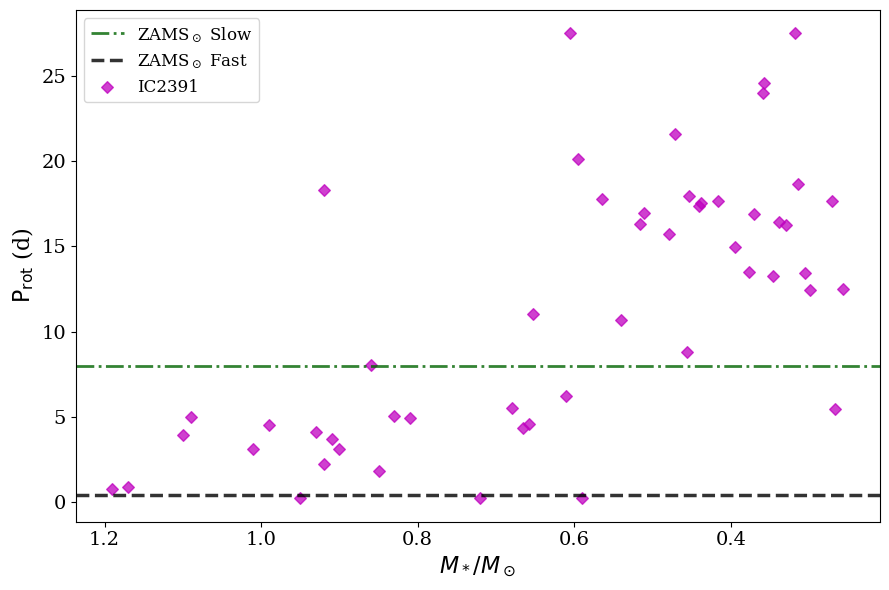

In [52]:
# Now we are ready to plot all the datasets
fig, ax = plt.subplots()

ax.scatter(cross_match[is_period]['mass'], cross_match[is_period]['period'], 
           marker='D', s=35, c='m', alpha=0.75, label='IC2391')

# Plot ZAMS relevant boundaries
ax.axhline(slow_period, lw=2.0, c='darkgreen', ls='-.', alpha=0.8, label='ZAMS$_\odot$ Slow')
ax.axhline(fast_period, lw=2.5, c='k', ls='--', alpha=0.8, label='ZAMS$_\odot$ Fast')

ax.set_xlabel('$M_*/M_\odot$')
ax.set_ylabel('$\mathrm{P_{rot}}$ (d)')
ax.invert_xaxis()
ax.legend(fontsize=12)
ax.set_rasterized(True)
fig.tight_layout()
plt.savefig('SyntheticComparison/invalid_ZAMS_comp.pdf')
plt.savefig('SyntheticComparison/invalid_ZAMS_comp.eps')